In [3]:
import numpy as np
import tensorflow as tf
from collections import deque
import gym
import threading
import time
import random
import subprocess
import sys
GITPATH = subprocess.run('git rev-parse --show-toplevel'.split(' '), \
        stdout=subprocess.PIPE).stdout.decode('utf-8').replace('\n','')
sys.path.append(GITPATH)
import dobroEnv


/home/lgm/JEONGHO/ATARI/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lgm/JEONGHO/ATARI/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lgm/JEONGHO/ATARI/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lgm/JEONGHO/ATARI/lib/python3.5/site-packages/tensorflow/python/framework

In [106]:
ENVIRONMENT_NAME = 'HalfCheetahBulletEnv-v0'
STATE_SHAPE = 26
# ACTION_NUMBER = 11
ACTION_DIM = 6
GAMMA = 0.99
# T_MAX = 5
MAX_STEP = 1000000
REPLAY_BUFFER_SIZE = 50000
SOFT_UPDATE_TAU = 0.01
BATCH_SIZE = 32
TRAIN_STARTING_POINT = 5000
test_env = gym.make(ENVIRONMENT_NAME)
MAX_ACTION = test_env.action_space.high[0]
MIN_ACTION = test_env.action_space.low[0]

In [107]:
class ReplayBuffer():
    def __init__(self):
        self.history = deque([], maxlen = REPLAY_BUFFER_SIZE)
    def update(self, state, action, reward, next_state, done):
        buffer = (state, action, reward, next_state, done)
        self.history.append(buffer)
        
    def sample_batch(self):
        batch = random.sample(self.history, BATCH_SIZE)
        return batch

In [110]:
class Agent():
    def __init__(self):
        self.replay = ReplayBuffer() # args add
                
        self.input_state = tf.placeholder(shape=(None, STATE_SHAPE),dtype=tf.float32, name='stateph')
        self.input_action = tf.placeholder(shape=(None, ACTION_DIM),dtype=tf.float32, name='actionph')

        self.tau = SOFT_UPDATE_TAU
        self.gamma = GAMMA
            
        self.policy_online = self._build_actor_network('online')
        self.policy_target = self._build_actor_network('target')
        
        self.value_online = self._build_critic_network('online')
        self.value_target = self._build_critic_network('target')
        
        self.online_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'online')
        self.online_policy_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'online/actor')
        self.online_value_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'online/critic')
        
        self.target_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'target')
        self.target_policy_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'target/actor')
        self.target_value_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, ' target/critic')
        
        self.target_values  = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='tgph')
        self.value_loss = tf.reduce_sum(tf.square(self.value_online - self.target_values))
        self.value_gradient = tf.gradients(self.value_loss, self.online_value_variables)
        
        self.value_gradient_by_action = tf.gradients(self.value_online, self.input_action) # [batch * 1(value 개수) * actiondim(3)]  -> self.input_action이 online policy의 아웃풋임.
        self.value_gradient_by_action_placeholder = tf.placeholder(shape=(None, ACTION_DIM),dtype=tf.float32, name='vgaph')

        self.loss = - tf.matmul(tf.transpose(self.value_gradient_by_action_placeholder), self.policy_online)

        self.policy_gradient = tf.gradients(self.loss, self.online_policy_variables)
        
        self.policy_apply_grad = PolicyOptimizer.apply_gradients(zip(self.policy_gradient, self.online_policy_variables))
        self.value_apply_grad = ValueOptimizer.apply_gradients(zip(self.value_gradient, self.online_value_variables))
        
        self.target_update_ops = self._build_target_update_ops()


    def _build_actor_network(self, name):
        # actor(policy) - input: state, output: action(real number vector) 
        with tf.variable_scope(name):
            actor_L1 = tf.layers.dense(inputs=self.input_state, units=128, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='actor_1') # name = actor
            actor_L2 = tf.layers.dense(inputs=actor_L1, units=128, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='actor_2') # name = actor
            policy_output = tf.layers.dense(inputs=actor_L2, units=ACTION_DIM, activation=tf.nn.tanh, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='actor_3') # tanh activation
            
        return policy_output
    def _build_critic_network(self, name):
        # critic(Q-value) - input: state+action, output: real number Q-value
        with tf.variable_scope(name):
            critic_L1 = tf.layers.dense(inputs=tf.concat([self.input_state, self.input_action], axis=1), units=128, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='critic_1')
            critic_L2 = tf.layers.dense(inputs=critic_L1, units=128, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='critic_2')
            value_output = tf.layers.dense(inputs=critic_L2, units=1, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='critic_3')
        
        return value_output

            
    def sync_network(self):
        ops = []
        for target_var, online_var in zip(self.target_variables, self.online_variables):
            ops.append(target_var.assign(online_var))
            
        for op in ops:
            sess.run(op)

            
    def _build_target_update_ops(self):
        #variables = variables*(1-self.tau) + new_variables*self.tau
        ops = []
        for target_var, online_var in zip(self.target_variables, self.online_variables):
            ops.append(target_var.assign(self.tau * online_var + (1-self.tau) * target_var))
        return ops
    
    def target_update(self):
        for op in self.target_update_ops:
            sess.run(op)            
            
    def action_preprocess(self, action):
        actions = action[0]
        noisy_action = []
        noises = np.random.normal(loc=0, scale=0.1, size=ACTION_DIM)

        for i in range(ACTION_DIM):
            noisy_action.append(np.clip(actions[i] + noises[i],-1, 1))

        return noisy_action
            
    def action_sample(self,state, evaluate=False) :
        action = sess.run(self.policy_online, feed_dict={self.input_state:[state]}) # state에 괄호 쳐야하는지 조심, action_dist에서 괄호 하나 빼야하는지도 조심
        if evaluate==False:
            action = self.action_preprocess(action)
        else:
            action = action[0]

        value = sess.run(self.value_online, feed_dict={self.input_state:[state], self.input_action:[action]})
        
        return action, value
    def train(self):
        if len(self.replay.history) < TRAIN_STARTING_POINT:
            return None
        batches = self.replay.sample_batch()
        states, actions, rewards, next_states, dones = [],[],[],[],[]
        
        for batch in batches:
            states.append(batch[0])
            actions.append(batch[1])
            rewards.append(batch[2])
            next_states.append(batch[3])
            dones.append(batch[4])
        target_values = []
        next_policy_target_outputs = sess.run(self.policy_target, feed_dict={self.input_state:next_states})
        next_value_target_outputs = sess.run(self.value_target, feed_dict={self.input_state:next_states, self.input_action:next_policy_target_outputs})
        for i in range(len(batches)):
            if dones[i]==True:
                target_value = rewards[i] +  self.gamma *  next_value_target_outputs[i] # pendulum일때 특별히
            else:
                target_value = rewards[i] +  self.gamma *  next_value_target_outputs[i]
            target_values.append(target_value)
        policy_online_outputs = sess.run(self.policy_online, feed_dict={self.input_state:states})
        value_gradient_by_action = sess.run(self.value_gradient_by_action, feed_dict={self.input_state:states, self.input_action:policy_online_outputs})[0]
        sess.run(self.value_apply_grad, feed_dict={self.input_state:states, self.input_action:actions, self.target_values:target_values})
        sess.run(self.policy_apply_grad, feed_dict={self.input_state:states, self.input_action:policy_online_outputs, self.value_gradient_by_action_placeholder:value_gradient_by_action})
        
        self.target_update()
        
        

In [115]:
## main
tf.reset_default_graph()
sess = tf.Session()
PolicyOptimizer = tf.train.AdamOptimizer(learning_rate = 3e-4)
ValueOptimizer = tf.train.AdamOptimizer(learning_rate = 3e-4)

agent = Agent()
sess.run(tf.global_variables_initializer())
agent.sync_network()

env = gym.make(ENVIRONMENT_NAME)

step_count = 0
episode_count = 0
rendering=False
score_deque = deque([],maxlen=20)
scores = []
while True:
    #episode
    score = 0
    episode_step_count = 0
    
    if episode_count%5==0:
        rendering=False
    if rendering==True:

        env.render()

    state = env.reset()
    episode_count += 1

    while True:
        action, value  = agent.action_sample(state)
       
        next_state, reward, done, _ = env.step(action)
        if rendering==True:
            env.render()

        agent.replay.update(state, action, reward, next_state, done)
        score += reward
        step_count += 1
        episode_step_count += 1
        agent.train()
        
        state = next_state
        
        if done:
            score_deque.append(score)
            scores.append(score)
            if rendering==True:                
                env.close()
                rendering=False
            
            
            break
        
    if episode_count%10==0:
        print('episode:', episode_count, 'score:', np.mean(score_deque), action)
    if episode_count%20==0:
        test_env = gym.make(ENVIRONMENT_NAME)
        testscore = 0
        test_env.render()
        teststate = test_env.reset()
        while True:
            testaction, _ = agent.action_sample(teststate, evaluate=True)
            testnext_state, testreward, testdone, _ = test_env.step(testaction)
            test_env.render()
            testscore += testreward
            teststate = testnext_state
            if testdone==True:
                print('TEST', testscore)
                test_env.close()
                break
            
    if episode_count>1000:
        print('max step')
        break
    
        
        
        




episode: 10 score: -1474.03134244038 [0.8981261159653579, 1.0, 0.8841812761143326, 0.9661202514302949, -0.9370960696612755, -0.9299338555711287]
episode: 20 score: -1538.433954189551 [1.0, 1.0, -0.8352989119313003, 0.8695971874541322, -0.9811841447267338, -0.17110547126620587]
TEST -1706.3286914600064
episode: 30 score: -1606.21371637935 [-0.9634652696504289, -0.1313793465914418, -0.9326877286018795, -0.7916005405927651, -1.0, -0.7936946056303419]
episode: 40 score: -1256.9056805821865 [-1.0, -0.2657238083061737, -0.9213566659531639, -0.7677776555556622, 0.45836086053269964, -0.9982575416128439]
TEST -1123.6264448907193
episode: 50 score: -1105.3601506505274 [0.5626773540917309, 1.0, -0.9565598325789505, -0.3439203867596021, 1.0, -1.0]
episode: 60 score: -1310.3700203165552 [0.9211804723302622, 0.9226759308935241, -1.0, -1.0, -0.7706747348225087, -0.983975198048358]
TEST -1586.7771024379845
episode: 70 score: -1103.1222539127762 [-1.0, -0.711955715302953, -0.7717796102765113, -0.853039

episode: 340 score: 118.91559719738468 [1.0, 1.0, 0.868187561319855, 0.8600811020512221, 0.9988016685088767, 0.8614872231741619]
TEST 349.52335921916205
episode: 350 score: 103.93675493713408 [-0.8043081768887143, -0.899367753986891, -0.7679280265002442, -0.5600381293395844, -0.6224475688974982, -0.9008871442853202]
episode: 360 score: 100.35513007224384 [0.3221131507194812, 0.7049287091062366, -0.6330883295140013, -0.60712461467628, 0.8354186329682791, 0.6167968672646882]
TEST -318.7886855430047
episode: 370 score: 202.45496312254645 [1.0, 1.0, 0.3859677681342769, -0.28649122459495696, 1.0, 1.0]
episode: 380 score: 420.29244289869365 [-0.9042900920939628, -0.9454828464952069, -0.8856815114170404, -0.9772909503240279, -0.8299570803994063, -1.0]
TEST 243.0352281788902
episode: 390 score: 580.7327210098842 [0.9307993583412201, 0.9024035850466741, 0.8745728159470767, 1.0, 1.0, 1.0]
episode: 400 score: 661.439331772923 [1.0, 1.0, 0.9069662453647178, 0.9260671912125695, 0.5555653385400159, 

TEST 590.389610373716
episode: 950 score: 591.1340835494491 [0.8434200041400641, 0.8884948666136091, 1.0, 1.0, 0.96148172654709, 1.0]
episode: 960 score: 630.5292540419102 [0.9747754307049533, 0.9944638202204055, -0.7913200489162575, -0.916701159916171, 0.9417033517703141, -0.5432128279456087]
TEST 711.0132303755536
episode: 970 score: 653.7188688889722 [1.0, 1.0, 0.8029255344984858, -0.6840388825260922, 0.9590111551745255, 0.682920899937754]
episode: 980 score: 672.0191040515627 [1.0, 0.9262488784676093, 0.9361898126101975, 1.0, 1.0, 0.8271577254183182]
TEST 572.5327559415335
episode: 990 score: 675.427273532679 [1.0, 1.0, 0.9007360830722679, 1.0, 1.0, 0.8665191213779333]
episode: 1000 score: 599.8150778607652 [-0.9482497306103349, 0.7033076954084296, -0.9835514018652964, -1.0, -0.9522306388067043, -0.899140263732732]
TEST 632.395350583852
max step


In [119]:
test_env = gym.make(ENVIRONMENT_NAME)
testscore = 0
test_env.render()
teststate = test_env.reset()
while True:
    testaction, _ = agent.action_sample(teststate, evaluate=False)
    testnext_state, testreward, testdone, _ = test_env.step(testaction)
    test_env.render()
    time.sleep(0.01)
    testscore += testreward
    teststate = testnext_state
    if testdone==True:
        print('TEST', testscore)
        test_env.close()
        break

TEST 521.9683878238885


In [87]:
env.close()

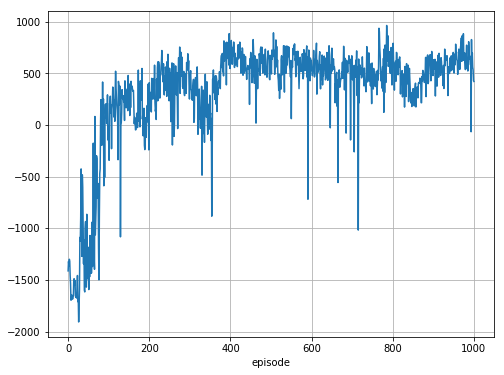

In [116]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(scores)
plt.xlabel('episode')
plt.grid()

0